In [23]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils import data
import torchvision #加载图片
from torchvision import transforms #图片变换
 
import numpy as np
import matplotlib.pyplot as plt #绘图
import os
import glob
from PIL import Image
 

Pix2Pix是基于条件生成对抗网络（cGAN, Condition Generative Adversarial Networks ）实现的一种深度学习图像转换模型，该模型是由Phillip Isola等作者在2017年CVPR上提出的,可以实现语义/标签到真实图片、灰度图到彩色图、航空图到地图、白天到黑夜、线稿图到实物图的转换。Pix2Pix是将cGAN应用于有监督的图像到图像翻译的经典之作，其包括两个模型：生成器和判别器。


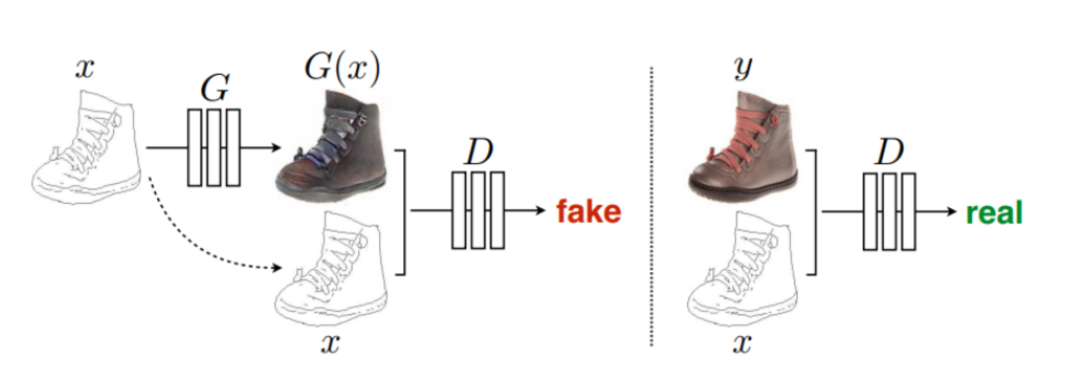

Pix2pixgan本质上是一个cgan，图片x作为此cGAN的条件，需要输入到G和D中。G的输入是x(x是需要转换的图片)，输出是生成的图片G(x)。D则需要分辨出（x，G(x)）和(x，y）

pix2pixGAN生成器的设计

对于图像翻译任务来说，输入和输出之间会共享很多信息。比如轮廓信息是共享的。如何解决共享问题？需要我们从损失函数的设计当中去思考。

如果使用普通的卷积神经网络，那么会导致每一层都承载保存着所有的信息。这样神经网络很容易出错（容易丢失一些信息）

所以，我们使用UNet模型作为生成器


pix2pixGAN主要用于图像之间的转换，又称图像翻译。

In [24]:
# imgs_path = glob.glob('base/*.jpg')
# annos_path = glob.glob('base/*.png')



In [25]:
# #预处理
# transform = transforms.Compose([
#     transforms.ToTensor(),
#     transforms.Resize((256,256)),
#     transforms.Normalize(mean=0.5,std=0.5
#                 )
    
# ])
 
# #定义数据集
# class CMP_dataset(data.Dataset):
#     def __init__(self,imgs_path,annos_path):
#         self.imgs_path =imgs_path
#         self.annos_path = annos_path
#     def __getitem__(self,index): 
#         img_path = self.imgs_path[index]
#         anno_path = self.annos_path[index]
#         pil_img = Image.open(img_path) #读取数据
#         pil_img = transform(pil_img)  #转换数据
#         anno_img = Image.open(anno_path) #读取数据
#         anno_img = anno_img.convert("RGB")
#         pil_anno = transform(anno_img)  #转换数据
#         return pil_anno,pil_img
#     def __len__(self):
#         return len(self.imgs_path)
 

In [26]:
from typing import List, Tuple, Dict

In [27]:
MEAN = (0.5, 0.5, 0.5,)
STD = (0.5, 0.5, 0.5,)
RESIZE = 64

def read_path(filepath)->List[str] :## train  val
    root_path = "/kaggle/input/pix2pix-maps/"
    path = os.path.join(root_path, filepath)
    dataset = []
#     for p in glob(path+"/"+"*.jpg"):
    for p in glob.glob(os.path.join(path, "*.jpg")):
        dataset.append(p)
    return dataset 


class Transform():
    def __init__(self, resize=RESIZE, mean=MEAN, std=STD):
        self.data_transform = transforms.Compose([
            transforms.Resize((resize, resize)), 
            transforms.ToTensor(),
            transforms.Normalize(mean, std)
        ])
        
    def __call__(self, img: Image.Image):
        return self.data_transform(img)

    
class Dataset(object):
    def __init__(self, files: List[str]):
        self.files = files 
        self.trasformer = Transform()
        
    def _separate(self, img) -> Tuple[Image.Image, Image.Image]:
        img = np.array(img, dtype=np.uint8)
        h, w, _ = img.shape
        w = int(w/2)
        return Image.fromarray(img[:, w:, :]), Image.fromarray(img[:, :w, :])
    
    def __getitem__(self, idx: int) -> Tuple[torch.Tensor, torch.Tensor]:
        img = Image.open(self.files[idx])
        input, output = self._separate(img)
        input_tensor = self.trasformer(input)
        output_tensor = self.trasformer(output)
        return input_tensor, output_tensor 
    
    def __len__(self):
        return len(self.files)

In [28]:
# root_path = "/kaggle/input/pix2pix-maps/"
# path = os.path.join(root_path, "train")
# dataset = []
# for p in glob.glob(os.path.join(path, "*.jpg")):
#     dataset.append(p)
# dataset 

In [29]:
# listPath=read_path("train")
# listPath[:4]

In [30]:
#创建数据集
# dataset = CMP_dataset(imgs_path,annos_path)
listPath=read_path("train")
dataset=Dataset(listPath)
dataset

In [31]:
#将数据转化为dataloader的格式，方便迭代
BATCHSIZE = 32
dataloader = data.DataLoader(dataset,
                            batch_size = BATCHSIZE,
                            shuffle = True)
annos_batch,imgs_batch = next(iter(dataloader))
 

In [32]:
#定义下采样模块
class Downsample(nn.Module):
    def __init__(self,in_channels,out_channels):
        super(Downsample,self).__init__()
        self.conv_relu = nn.Sequential(
        nn.Conv2d(in_channels,out_channels,
                 kernel_size=3,
                 stride=2,
                 padding=1),
        nn.LeakyReLU(inplace=True))
        self.bn = nn.BatchNorm2d(out_channels)
    def forward(self,x,is_bn=True):
        x=self.conv_relu(x)
        if is_bn:
            x=self.bn(x)
        return x
 
 
#定义上采样模块
class Upsample(nn.Module):
    def __init__(self,in_channels,out_channels):
        super(Upsample,self).__init__()
        self.upconv_relu = nn.Sequential(
        nn.ConvTranspose2d(in_channels,out_channels,
                 kernel_size=3,
                 stride=2,
                 padding=1,
                 output_padding=1), #反卷积，变为原来的2倍
        nn.LeakyReLU(inplace=True))
        self.bn = nn.BatchNorm2d(out_channels)
    def forward(self,x,is_drop=False):
        x=self.upconv_relu(x)
        x=self.bn(x)
        if is_drop:
            x=F.dropout2d(x)
        return x
        
 
#定义生成器：包含6个下采样，5个上采样，一个输出层
class Generator(nn.Module):
    def __init__(self):
        super(Generator,self).__init__()
        self.down1 = Downsample(3,64)      #64,128,128
        self.down2 = Downsample(64,128)    #128,64,64
        self.down3 = Downsample(128,256)   #256,32,32
        self.down4 = Downsample(256,512)   #512,16,16
        self.down5 = Downsample(512,512)   #512,8,8
        self.down6 = Downsample(512,512)   #512,4,4
        
        self.up1 = Upsample(512,512)    #512,8,8
        self.up2 = Upsample(1024,512)   #512,16,16
        self.up3 = Upsample(1024,256)   #256,32,32
        self.up4 = Upsample(512,128)    #128,64,64
        self.up5 = Upsample(256,64)     #64,128,128
        
        self.last = nn.ConvTranspose2d(128,3,
                                      kernel_size=3,
                                      stride=2,
                                      padding=1,
                                      output_padding=1)  #3,256,256
        
    def forward(self,x):
        x1 = self.down1(x)
        x2 = self.down2(x1)
        x3 = self.down3(x2)
        x4 = self.down4(x3)
        x5 = self.down5(x4)
        x6 = self.down6(x5)
        
        x6 = self.up1(x6,is_drop=True)
        x6 = torch.cat([x6,x5],dim=1)
        
        x6 = self.up2(x6,is_drop=True)
        x6 = torch.cat([x6,x4],dim=1)
        
        x6 = self.up3(x6,is_drop=True)
        x6 = torch.cat([x6,x3],dim=1)
        
        x6 = self.up4(x6)
        x6 = torch.cat([x6,x2],dim=1)
        
        x6 = self.up5(x6)
        x6 = torch.cat([x6,x1],dim=1)
        
        
        x6 = torch.tanh(self.last(x6))
        return x6
 
#定义判别器  输入anno+img(生成或者真实)  concat
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator,self).__init__()
        self.down1 = Downsample(6,64)
        self.down2 = Downsample(64,128)
        self.conv1 = nn.Conv2d(128,256,3)
        self.bn = nn.BatchNorm2d(256)
        self.last = nn.Conv2d(256,1,3)
    def forward(self,anno,img):
        x=torch.cat([anno,img],axis =1) 
        x=self.down1(x,is_bn=False)
        x=self.down2(x,is_bn=True)
        x=F.dropout2d(self.bn(F.leaky_relu(self.conv1(x))))
        x=torch.sigmoid(self.last(x))  #batch*1*60*60
        return x
 
device = "cuda" if torch.cuda.is_available() else'cpu'
gen = Generator().to(device)
dis = Discriminator().to(device)
d_optimizer = torch.optim.Adam(dis.parameters(),lr=1e-3,betas=(0.5,0.999))
g_optimizer = torch.optim.Adam(gen.parameters(),lr=1e-3,betas=(0.5,0.999))
#绘图
def generate_images(model,test_anno,test_real):
    prediction = model(test_anno).permute(0,2,3,1).detach().cpu().numpy()
    test_anno = test_anno.permute(0,2,3,1).cpu().numpy()
    test_real = test_real.permute(0,2,3,1).cpu().numpy()
    plt.figure(figsize = (10,10))
    display_list = [test_anno[0],test_real[0],prediction[0]]
    title = ['Input','Ground Truth','Output']
    for i in range(3):
        plt.subplot(1,3,i+1)
        plt.title(title[i])
        plt.imshow(display_list[i])
        plt.axis('off') #坐标系关掉
    plt.show()
 
# test_imgs_path = glob.glob('extended/*.jpg')
# test_annos_path = glob.glob('extended/*.png')
 
# test_dataset = CMP_dataset(test_imgs_path,test_annos_path)
listPath_val=read_path("val")
test_dataset=Dataset(listPath_val)

 
test_dataloader = torch.utils.data.DataLoader(
test_dataset,
batch_size=BATCHSIZE,)
 
#定义损失函数
#cgan 损失函数
loss_fn = torch.nn.BCELoss()
#L1 loss
 
 

Epoch: 0


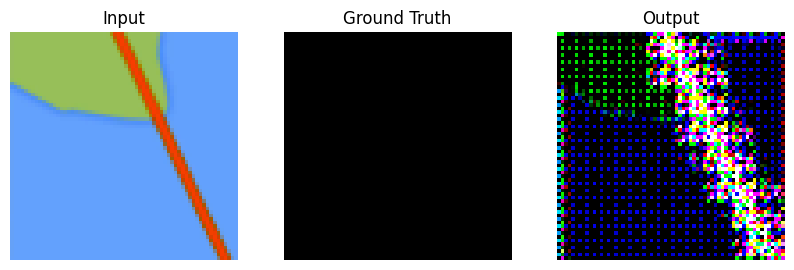

Epoch: 1


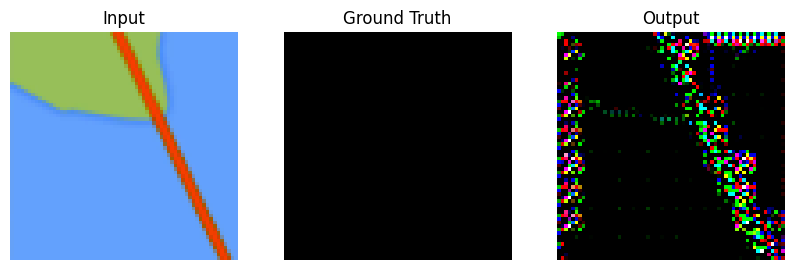

Epoch: 2


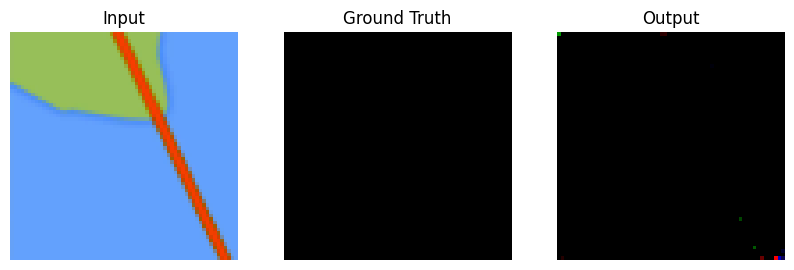

Epoch: 3


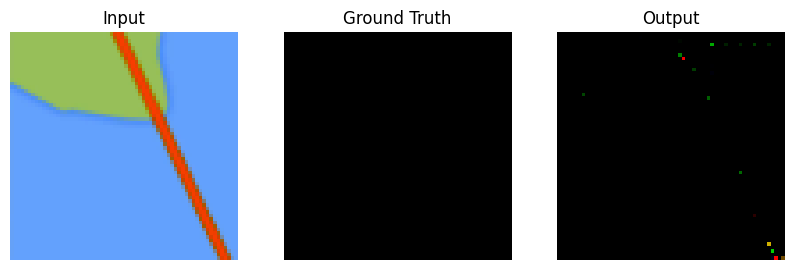

In [ ]:
annos_batch,imgs_batch = annos_batch.to(device),imgs_batch.to(device)
LAMBDA = 7  #L1损失的权重
 
D_loss = []#记录训练过程中判别器loss变化
G_loss = []#记录训练过程中生成器loss变化
 
#开始训练
for epoch in range(100):
    D_epoch_loss = 0
    G_epoch_loss = 0
    count = len(dataloader)
    for step,(annos,imgs) in enumerate(dataloader):
        imgs = imgs.to(device)
        annos = annos.to(device)
        #定义判别器的损失计算以及优化的过程
        d_optimizer.zero_grad()
        disc_real_output = dis(annos,imgs)#输入真实成对图片
        d_real_loss = loss_fn(disc_real_output,torch.ones_like(disc_real_output,
                                                             device=device))
        d_real_loss.backward()
        
        gen_output = gen(annos)
        disc_gen_output = dis(annos,gen_output.detach())
        d_fack_loss = loss_fn(disc_gen_output,torch.zeros_like(disc_gen_output,
                                                              device=device))
        d_fack_loss.backward()
        
        disc_loss = d_real_loss+d_fack_loss#判别器的损失计算
        d_optimizer.step()
        
        #定义生成器的损失计算以及优化的过程
        g_optimizer.zero_grad()
        disc_gen_out = dis(annos,gen_output)
        gen_loss_crossentropyloss = loss_fn(disc_gen_out,
                                            torch.ones_like(disc_gen_out,
                                                              device=device))
        gen_l1_loss = torch.mean(torch.abs(gen_output-imgs))
        gen_loss = gen_loss_crossentropyloss +LAMBDA*gen_l1_loss
        gen_loss.backward() #反向传播
        g_optimizer.step() #优化
        
        #累计每一个批次的loss
        with torch.no_grad():
            D_epoch_loss +=disc_loss.item()
            G_epoch_loss +=gen_loss.item()
    #求平均损失
    with torch.no_grad():
            D_epoch_loss /=count
            G_epoch_loss /=count
            D_loss.append(D_epoch_loss)
            G_loss.append(G_epoch_loss)
            #训练完一个Epoch,打印提示并绘制生成的图片
            print("Epoch:",epoch)
            generate_images(gen,annos_batch,imgs_batch)